# NLP Visualizations

In [2]:
!aws s3 ls


2023-08-29 23:43:16 sagemaker-studio-692960231031-wo7kgoszj2g
2023-08-29 23:50:01 sagemaker-us-east-1-692960231031
2023-08-30 00:34:21 vad49
2023-09-16 16:02:10 vad49-labdata


In [3]:
!aws s3 ls s3://project17-bucket-alex/stories-and-books-nlp/


                           PRE mapping/
                           PRE processed-data/


In [4]:
if True is True: # set to true only for the first un
    # Setup - Run only once per Kernel App
    %conda install openjdk -y

    # install PySpark
    %pip install pyspark==3.2.0 s3fs pyarrow

    # restart kernel
    from IPython.core.display import HTML
    HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
  Using cached pyspark-3.2.0-py2.py3-none-any.whl
  Using cached py4j-0.10.9.2-py2.py3-none-any.whl (198 kB)
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.4.0
    Uninstalling pyspark-3.4.0:
      Successfully uninstalled pyspark-3.4.0

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel 

In [5]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import col, length, isnan, when, count, regexp_extract, weekofyear, hour, avg, to_date, unix_timestamp, lit, corr


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 150) 
#pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)


In [6]:
# Import pyspark and build Spark session

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    #.config("spark-jars-packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-527fd906-8f78-4429-be41-a557ef37cd1a;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 315ms :: artifacts dl 18ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


In [7]:
# read in the data

all_model_text = spark.read.parquet("s3a://project17-bucket-alex/stories-and-books-nlp/processed-data/")

display(f"shape: ({all_model_text.count()}, {len(all_model_text.columns)})")
all_model_text.show()

23/11/18 21:50:21 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


'shape: (12161, 3)'

+--------------------+--------------------+--------------------+
|                text|       custom_tokens|         text_as_int|
+--------------------+--------------------+--------------------+
|First of all, I n...|[first,  , of,  ,...|[22, 25, 34, 35, ...|
|I started a job a...|[i,  , started,  ...|[25, 1, 35, 36, 1...|
|My older brother ...|[my,  , older,  ,...|[29, 41, 1, 31, 2...|
|When I was a kid,...|[when,  , i,  , w...|[39, 24, 21, 30, ...|
|TL/DR on bottom!\...|[tldr,  , on,  , ...|[36, 28, 20, 34, ...|
|I have many stori...|[i,  , have,  , m...|[25, 1, 24, 17, 3...|
| \n\nFaults in Ma...|[ , faults,  , in...|[1, 22, 17, 37, 2...|
|My (24F) boyfrien...|[my,  , 24f,  , b...|[29, 41, 1, 7, 9,...|
|So, this wasn't r...|[so, ,,  , this, ...|[35, 31, 3, 1, 36...|
|\nEDIT: Hi! Still...|[edit,  , hi, !, ...|[21, 20, 25, 36, ...|
|tl;dr: So basical...|[tl, ;, dr,  , so...|[36, 28, 15, 20, ...|
|Obligatory, I mis...|[obligatory, ,,  ...|[31, 18, 28, 25, ...|
|Warning: mentions...|[wa

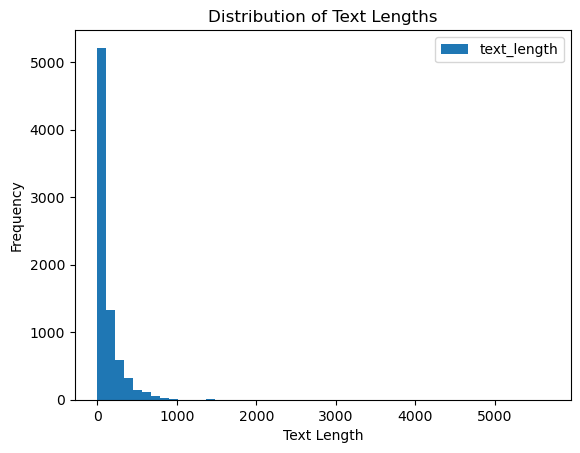

+-----+------+
|token| count|
+-----+------+
|     |452467|
|    ,| 37939|
|    .| 27220|
|  the| 20261|
|  and| 15451|
|   to| 11528|
|   of| 10736|
|    a|  9276|
|   he|  7851|
|    i|  7305|
|   in|  6926|
|  you|  5857|
|   it|  5772|
| that|  5537|
|  was|  5336|
|  his|  4627|
| with|  3966|
|  for|  3624|
|  her|  3566|
|   as|  3504|
+-----+------+
only showing top 20 rows



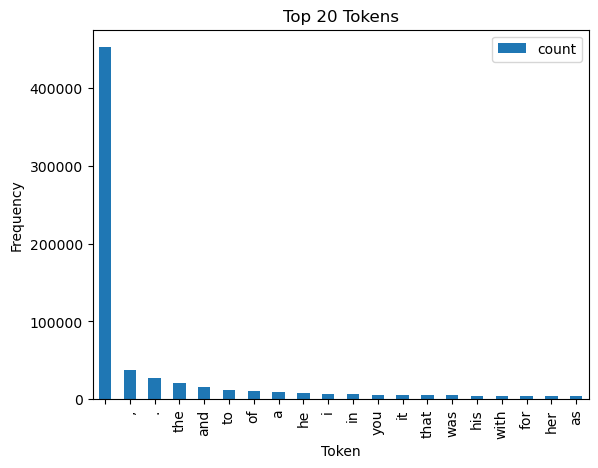

+-------+------+
|int_val| count|
+-------+------+
|      1|452467|
|     21|260751|
|     36|191572|
|     17|170645|
|     31|167276|
|     30|145371|
|     25|143036|
|     24|141535|
|     35|132297|
|     34|118120|
|     20| 92679|
|     28| 85853|
|     37| 63235|
|     29| 55376|
|     39| 52185|
|     41| 46567|
|     22| 44690|
|     19| 44640|
|     23| 43835|
|      3| 37939|
+-------+------+
only showing top 20 rows



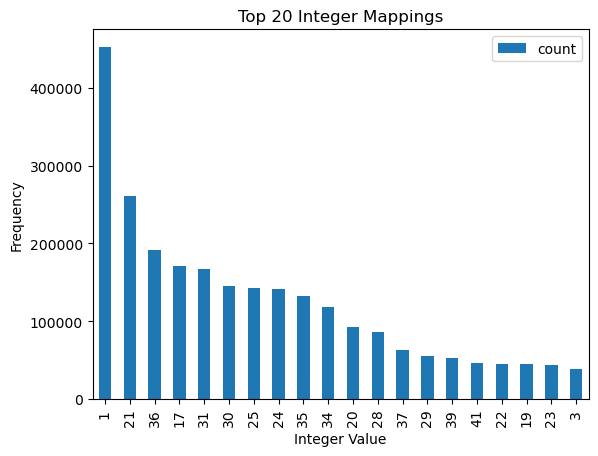

+--------------------+--------------------+--------------------+
|                text|       custom_tokens|         text_as_int|
+--------------------+--------------------+--------------------+
|       Metamorphosis|     [metamorphosis]|[29, 21, 36, 17, ...|
|      by Franz Kafka|[by,  , franz,  ,...|[18, 41, 1, 22, 3...|
|Translated by Dav...|[translated,  , b...|[36, 34, 17, 30, ...|
|                   I|                 [i]|                [25]|
|One morning, when...|[one,  , morning,...|[31, 30, 21, 1, 2...|
|“What’s happened ...|[whats,  , happen...|[39, 24, 17, 36, ...|
|Gregor then turne...|[gregor,  , then,...|[23, 34, 21, 23, ...|
|“Oh, God”, he tho...|[oh, ,,  , god, ,...|[31, 24, 3, 1, 23...|
|He slid back into...|[he,  , slid,  , ...|[24, 21, 1, 35, 2...|
|And he looked ove...|[and,  , he,  , l...|[17, 30, 20, 1, 2...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [14]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import size, explode




# 1. Text Length Analysis
all_model_text.withColumn('text_length', size('custom_tokens')).select('text_length').toPandas().plot(kind='hist', bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 2. Token Frequency Analysis
token_freq = all_model_text.withColumn('token', explode('custom_tokens')).groupBy('token').count().orderBy('count', ascending=False)
token_freq.show()
token_freq.toPandas().head(20).plot(kind='bar', x='token', y='count')
plt.title('Top 20 Tokens')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.show()

# 3. Token-to-Integer Mapping Analysis
int_freq = all_model_text.withColumn('int_val', explode('text_as_int')).groupBy('int_val').count().orderBy('count', ascending=False)
int_freq.show()
int_freq.toPandas().head(20).plot(kind='bar', x='int_val', y='count')
plt.title('Top 20 Integer Mappings')
plt.xlabel('Integer Value')
plt.ylabel('Frequency')
plt.show()

# 4. Sample Data Table
all_model_text.show(10)




+--------------+-----+
|         ngram|count|
+--------------+-----+
|    of   the  | 1941|
|    in   the  | 1605|
|    to   the  | 1113|
|    on   the  |  847|
|    he   was  |  710|
|    it   was  |  705|
|    he   had  |  698|
|    at   the  |  679|
|   and   the  |  650|
|     to   be  |  595|
|      in   a  |  546|
|     . . . .  |  537|
|      i   am  |  523|
|    with   a  |  523|
|   that   he  |  494|
|  from   the  |  488|
|      of   a  |  482|
|   for   the  |  461|
|    of   his  |  448|
|     was   a  |  430|
+--------------+-----+
only showing top 20 rows



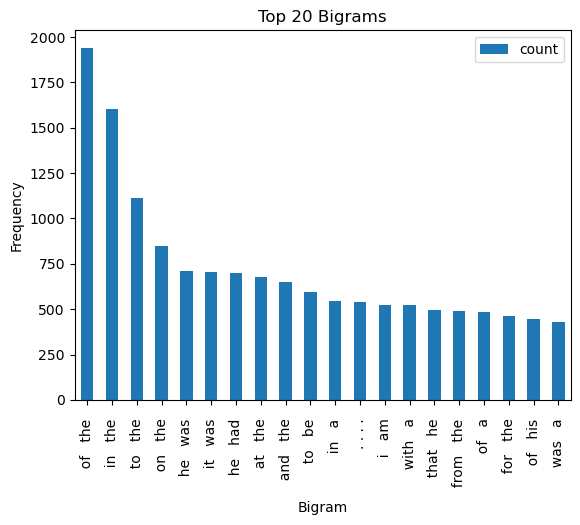

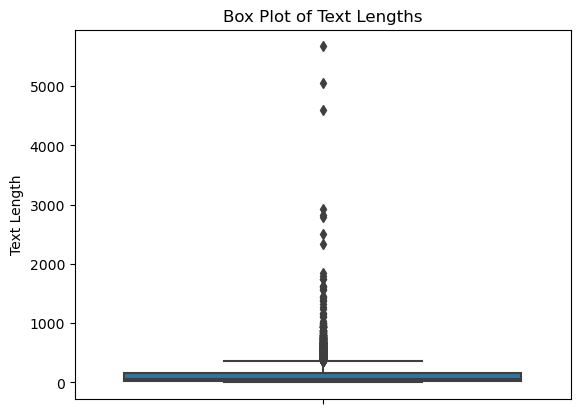

+--------------------+--------------------+--------------------+
|                text|       custom_tokens|         text_as_int|
+--------------------+--------------------+--------------------+
|       Metamorphosis|     [metamorphosis]|[29, 21, 36, 17, ...|
|      by Franz Kafka|[by,  , franz,  ,...|[18, 41, 1, 22, 3...|
|Translated by Dav...|[translated,  , b...|[36, 34, 17, 30, ...|
|                   I|                 [i]|                [25]|
|One morning, when...|[one,  , morning,...|[31, 30, 21, 1, 2...|
|“What’s happened ...|[whats,  , happen...|[39, 24, 17, 36, ...|
|Gregor then turne...|[gregor,  , then,...|[23, 34, 21, 23, ...|
|“Oh, God”, he tho...|[oh, ,,  , god, ,...|[31, 24, 3, 1, 23...|
|He slid back into...|[he,  , slid,  , ...|[24, 21, 1, 35, 2...|
|And he looked ove...|[and,  , he,  , l...|[17, 30, 20, 1, 2...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [17]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import size, explode, col
import pandas as pd







# 2. N-Gram Analysis
from pyspark.ml.feature import NGram

ngram = NGram(n=5, inputCol="custom_tokens", outputCol="ngrams")
ngram_df = ngram.transform(all_model_text)
ngram_freq = ngram_df.withColumn('ngram', explode('ngrams')).groupBy('ngram').count().orderBy('count', ascending=False)
ngram_freq.show()
ngram_freq.toPandas().head(20).plot(kind='bar', x='ngram', y='count')
plt.title('Top 20 Bigrams')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.show()

# 3. Text Length Box Plot
lengths_pd = all_model_text.withColumn('text_length', size('custom_tokens')).select('text_length').toPandas()
sns.boxplot(y=lengths_pd['text_length'])
plt.title('Box Plot of Text Lengths')
plt.ylabel('Text Length')
plt.show()

# Optional: Sentiment Analysis (requires additional setup and libraries)

# 4. Sample Data Table
all_model_text.show(10)



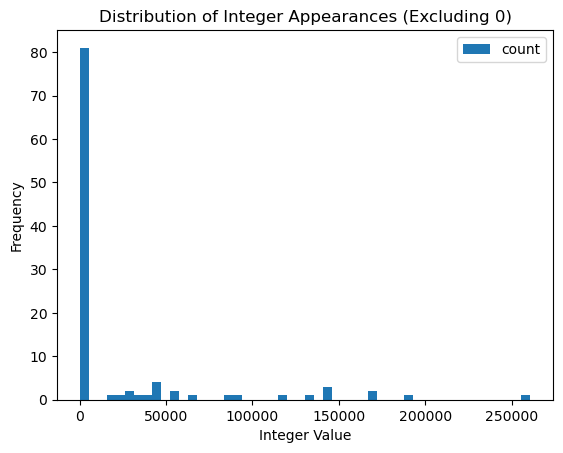

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, IntegerType

# Define a UDF to filter out zeros from the array
def filter_zeros(arr):
    return [num for num in arr if num != 1]

# Register UDF
filter_zeros_udf = udf(filter_zeros, ArrayType(IntegerType()))

# Apply the UDF to create a new column without zeros
all_model_text = all_model_text.withColumn("text_as_int_no_zero", filter_zeros_udf("text_as_int"))

# 4. Distribution of appearances in text_as_int excluding 0
int_freq_no_zero = all_model_text.withColumn('int_val', explode('text_as_int_no_zero')) \
                                 .groupBy('int_val').count()
int_freq_no_zero_pd = int_freq_no_zero.toPandas()
int_freq_no_zero_pd.plot(kind='hist', x='int_val', y='count', bins=50)
plt.title('Distribution of Integer Appearances (Excluding 0)')
plt.xlabel('Integer Value')
plt.ylabel('Frequency')
plt.show()
